<a href="https://colab.research.google.com/github/anmolkhurana490/Yoga-Posture-Recognition-and-Correction-System/blob/main/ai_yoga_trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install mediapipe

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import math
import random

In [2]:
import mediapipe as mp
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile

def extract_zip(dir_name):
  # Replace with the actual path to your zip file in Google Drive
  zip_file_path = f'/content/drive/MyDrive/AI yoga trainer/yoga_posture_dataset/{dir_name}.zip'
  # Replace with the desired extraction location in Colab
  extract_path = f'/content/yoga_posture_dataset/'
  try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(extract_path)
    print(f"Successfully unzipped {zip_file_path} to {extract_path}")
  except FileNotFoundError:
    print(f"Error: Zip file not found at {zip_file_path}")
  except Exception as e:
    print(f"An error occurred: {e}")

for dir_name in ['train_data', 'validation_data', 'test_data']:
  extract_zip(dir_name)

Successfully unzipped /content/drive/MyDrive/AI yoga trainer/yoga_posture_dataset/train_data.zip to /content/yoga_posture_dataset/
Successfully unzipped /content/drive/MyDrive/AI yoga trainer/yoga_posture_dataset/validation_data.zip to /content/yoga_posture_dataset/
Successfully unzipped /content/drive/MyDrive/AI yoga trainer/yoga_posture_dataset/test_data.zip to /content/yoga_posture_dataset/


In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
train_dir = '/content/yoga_posture_dataset/train_data'
validation_dir = '/content/yoga_posture_dataset/validation_data'
test_dir = '/content/yoga_posture_dataset/test_data'

In [7]:
mpPose=mp.solutions.pose
mpDraw=mp.solutions.drawing_utils
pose=mpPose.Pose(min_detection_confidence=0.7)

In [8]:
img=tf.io.read_file(f'{test_dir}/Akarna_Dhanurasana/image_1.jpg')
img=tf.image.decode_jpeg(img, channels=3)
results=pose.process(img.numpy())

(-0.5, 389.5, 249.5, -0.5)

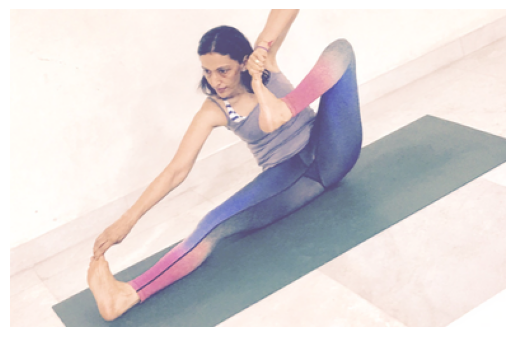

In [9]:
plt.imshow(img.numpy())
plt.axis('off')

In [10]:
# Rotate a point in 3D space by point (a,b,c)
def rotate_point(point, angles, arbitrary_point):
    """
    Rotate point (x,y,z) around pivot (a,b,c) by:
      - alpha around X-axis
      - beta  around Y-axis
      - gamma around Z-axis
    Angles in radians.
    Returns (x', y', z').
    """

    x, y, z = point
    a, b, c = arbitrary_point
    alpha, beta, gamma = angles

    ca, sa = math.cos(alpha), math.sin(alpha)
    cb, sb = math.cos(beta), math.sin(beta)
    cg, sg = math.cos(gamma), math.sin(gamma)

    x_prime = cg*(cb*(x - a) + sb*(sa*(y - b) + ca*(z - c))) - sg*(ca*(y - b) - sa*(z - c)) + a
    y_prime = sg*(cb*(x - a) + sb*(sa*(y - b) + ca*(z - c))) + cg*(ca*(y - b) - sa*(z - c)) + b
    z_prime = -sb*(x - a) + cb*(sa*(y - b) + ca*(z - c)) + c

    return x_prime, y_prime, z_prime

In [11]:
def visualize_landmarks(image_path):
  mp_drawing = mp.solutions.drawing_utils
  mp_pose = mp.solutions.pose

  with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)

    if results.pose_landmarks:
      # Draw landmarks on the image
      annotated_image = image.copy()
      mp_drawing.draw_landmarks(
          annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

      # Display the annotated image using Matplotlib
      plt.figure(figsize=(8, 8))
      plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
      plt.title("Pose Landmarks")
      plt.axis('off')  # Hide axes
      plt.show()
    else:
      print("No pose landmarks detected in the image.")

In [12]:
len(results.pose_landmarks.landmark)
# print(results.pose_landmarks.landmark)

33

(-0.5, 389.5, 249.5, -0.5)

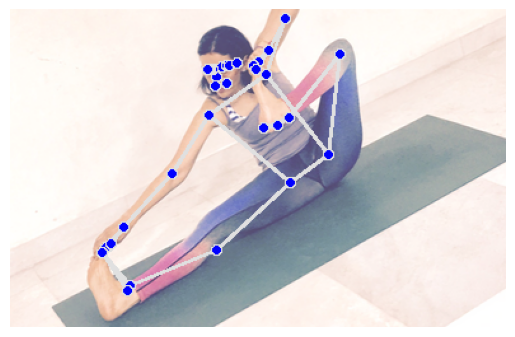

In [13]:
annonated_image = img.numpy().copy()
mpDraw.draw_landmarks(annonated_image, results.pose_landmarks, mpPose.POSE_CONNECTIONS)
plt.imshow(annonated_image)
plt.axis('off')

In [14]:
def normalize_keypoints_z(keypoints):
    """
    keypoints: numpy array of shape (33, 3), containing x, y, z.
    returns: normalized keypoints with z with reference to torse center
    """
    # Torso center points (average of shoulders and hips)
    torso_top = (keypoints[12] + keypoints[11]) / 2
    torso_bottom = (keypoints[24] + keypoints[23]) / 2
    torso_center = (torso_top + torso_bottom) / 2

    # Torso length in XY plane
    torso_length = np.linalg.norm(torso_top[:2] - torso_bottom[:2]) + 1e-8

    # Normalize Z by subtracting the torso center's Z coordinate
    keypoints[:, 2] = (keypoints[:, 2] - torso_center[2]) / torso_length

    return keypoints

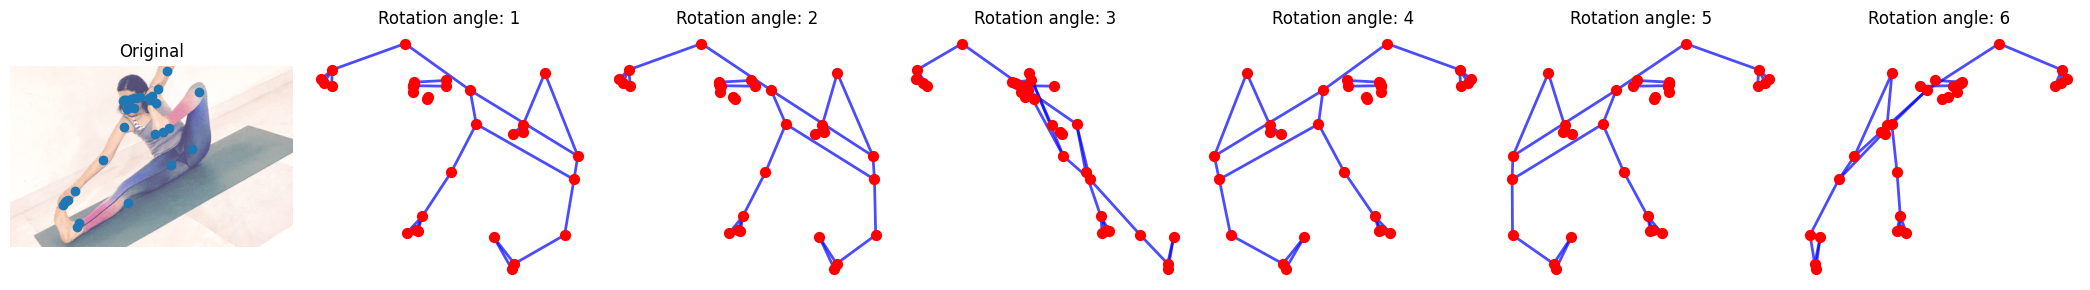

In [15]:
fig, axes = plt.subplots(1, 7, figsize=(21, 3)) # 7 subplots in one row

original_img_np = img.numpy().copy()
axes[0].imshow(original_img_np)
axes[0].scatter([landmark.x*len(img[0]) for landmark in results.pose_landmarks.landmark], [landmark.y*len(img) for landmark in results.pose_landmarks.landmark])
axes[0].set_title("Original")
axes[0].axis('off')

angles_list = [1,2,3,4,5,6]

for i, angle in enumerate(angles_list):
  rotated_img_np = img.numpy().copy()
  angles = (0, angle, 0) # Assuming rotation around Y-axis for visualization

  landmarks = [(landmark.x, landmark.y, landmark.z) for landmark in results.pose_landmarks.landmark]
  landmarks = np.array(landmarks)
  normalized_landmarks = normalize_keypoints_z(landmarks)

  rotated_landmarks = [rotate_point(point, angles, (0.5, 0.5, 0)) for point in normalized_landmarks]

  x_coords = [point[0] for point in rotated_landmarks]
  y_coords = [point[1] for point in rotated_landmarks]
  z_coords = [point[2] for point in rotated_landmarks]

  connections = mpPose.POSE_CONNECTIONS
  for connection in connections:
    start_idx, end_idx = connection
    axes[i+1].plot([x_coords[start_idx], x_coords[end_idx]],
                [y_coords[start_idx], y_coords[end_idx]],
                'blue', linewidth=2, alpha=0.7)

  # Draw landmarks
  axes[i+1].scatter(x_coords, y_coords, c='red', s=50, zorder=5)

  # axes[i+1].imshow(rotated_img_np)
  axes[i+1].invert_yaxis()
  axes[i+1].set_title(f"Rotation angle: {angle}")
  axes[i+1].axis('off')

plt.tight_layout()
plt.show()

In [16]:
landmarks = [(landmark.x, landmark.y, landmark.z) for landmark in results.pose_landmarks.landmark]
landmarks = np.array(landmarks)
print(np.array(normalize_keypoints_z(landmarks)))
# landmarks

[[ 0.41743332  0.21536551 -1.66998665]
 [ 0.42760938  0.18290463 -1.66694527]
 [ 0.43590268  0.17925268 -1.66646037]
 [ 0.44343913  0.1760394  -1.66681679]
 [ 0.4093906   0.1890741  -1.66061995]
 [ 0.40472507  0.18949938 -1.6610789 ]
 [ 0.4004764   0.18949941 -1.66091268]
 [ 0.45844886  0.16944346 -1.17367391]
 [ 0.39832807  0.19148278 -1.13718282]
 [ 0.43677408  0.23274115 -1.45251226]
 [ 0.41351172  0.24047758 -1.44338398]
 [ 0.51628804  0.20672119 -0.84075037]
 [ 0.40208745  0.33577859 -0.67089265]
 [ 0.55411232  0.02907017 -1.88132157]
 [ 0.32671458  0.51962453 -1.01477207]
 [ 0.52211404  0.12893382 -2.99850571]
 [ 0.2285175   0.68798757 -1.40505296]
 [ 0.5003444   0.16591349 -3.16427579]
 [ 0.19762933  0.74466676 -1.45349842]
 [ 0.49110973  0.17749864 -3.10339325]
 [ 0.19346911  0.75066137 -1.62434219]
 [ 0.49515179  0.18886447 -2.98943065]
 [ 0.2028631   0.73990768 -1.4838339 ]
 [ 0.64348638  0.45781076  0.76163072]
 [ 0.56660235  0.54682904  0.7500123 ]
 [ 0.66558194  0.14161119

In [17]:
classes = np.unique(os.listdir(train_dir))
num_classes = len(classes)
print("Number of classes:", num_classes)

Number of classes: 82


In [18]:
classes

array(['Akarna_Dhanurasana',
       'Bharadvajas_Twist_pose_or_Bharadvajasana_I_',
       'Boat_Pose_or_Paripurna_Navasana_',
       'Bound_Angle_Pose_or_Baddha_Konasana_', 'Bow_Pose_or_Dhanurasana_',
       'Bridge_Pose_or_Setu_Bandha_Sarvangasana_',
       'Camel_Pose_or_Ustrasana_', 'Cat_Cow_Pose_or_Marjaryasana_',
       'Chair_Pose_or_Utkatasana_', 'Child_Pose_or_Balasana_',
       'Cobra_Pose_or_Bhujangasana_', 'Cockerel_Pose',
       'Corpse_Pose_or_Savasana_', 'Cow_Face_Pose_or_Gomukhasana_',
       'Crane_(Crow)_Pose_or_Bakasana_',
       'Dolphin_Plank_Pose_or_Makara_Adho_Mukha_Svanasana_',
       'Dolphin_Pose_or_Ardha_Pincha_Mayurasana_',
       'Downward-Facing_Dog_pose_or_Adho_Mukha_Svanasana_',
       'Eagle_Pose_or_Garudasana_', 'Eight-Angle_Pose_or_Astavakrasana_',
       'Eka_Pada_Rajakapotasana',
       'Extended_Puppy_Pose_or_Uttana_Shishosana_',
       'Extended_Revolved_Side_Angle_Pose_or_Utthita_Parsvakonasana_',
       'Extended_Revolved_Triangle_Pose_or_Utthita

In [19]:
def count_images_in_directories(base_dir):
    counts = {}
    total = 0

    for class_name in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, class_name)
        if os.path.isdir(class_dir):
            image_count = len([name for name in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, name))])
            counts[class_name] = image_count
            total += image_count

    return counts, total

counts, total = count_images_in_directories(train_dir)
num_classes = len(counts)
class_weights = {label: total / (num_classes * count) for label, count in counts.items()}
print("Training set weights:", class_weights)
print("total images:", total)

Training set weights: {'Chair_Pose_or_Utkatasana_': 0.5878048780487805, 'Side-Reclining_Leg_Lift_pose_or_Anantasana_': 3.7696182396606575, 'Eka_Pada_Rajakapotasana': 0.7077650572424091, 'Upward_Plank_Pose_or_Purvottanasana_': 1.1333492746692173, 'Child_Pose_or_Balasana_': 0.5648287916103917, 'Head-to-Knee_Forward_Bend_pose_or_Janu_Sirsasana_': 1.3442049536774439, 'Tortoise_Pose': 1.5210740265297389, 'Noose_Pose_or_Pasasana_': 6.93609756097561, 'Frog_Pose_or_Bhekasana': 1.7000239120038259, 'Warrior_II_Pose_or_Virabhadrasana_II_': 0.7020341660906487, 'Cockerel_Pose': 1.6673311444652907, 'Side_Crane_(Crow)_Pose_or_Parsva_Bakasana_': 1.3037777370254906, 'Firefly_Pose_or_Tittibhasana_': 1.3762098335269066, 'Standing_Split_pose_or_Urdhva_Prasarita_Eka_Padasana_': 1.9055213079603324, 'Shoulder-Pressing_Pose_or_Bhujapidasana_': 2.477177700348432, 'Tree_Pose_or_Vrksasana_': 0.8065229722064663, 'Plow_Pose_or_Halasana_': 1.0023262371352037, 'Cow_Face_Pose_or_Gomukhasana_': 1.0200143472022956, 'Wi

In [20]:
print("Min count:", min(counts.values()), "Max weight:", max(class_weights.values()))
print("Max count:", max(counts.values()), "Min weight:", min(class_weights.values()))

Min count: 25 Max weight: 6.93609756097561
Max count: 644 Min weight: 0.269258445690047


In [21]:
label_lookup = tf.keras.layers.StringLookup(
    vocabulary = classes,
    mask_token = None,
    num_oov_indices = 0
)

In [22]:
def apply_noise_augmentation(keypoints, noise_factor=0.02):
    """
    Add small random noise to keypoints
    """
    noise = np.random.normal(0, noise_factor, keypoints.shape)
    return keypoints + noise

def apply_scale_augmentation(keypoints, scale_range=(0.9, 1.1)):
    """
    Apply random scaling to keypoints
    """
    scale = random.uniform(scale_range[0], scale_range[1])
    center = np.mean(keypoints, axis=0)
    return center + (keypoints - center) * scale

def comprehensive_augmentation(keypoints, num_augmentations=5):
    """
    Apply comprehensive augmentation including rotation, noise, and scaling
    """
    augmented_keypoints = []

    # Original keypoints
    augmented_keypoints.append(keypoints)

    # # Calculate center point (hip center as pivot)
    # left_hip = keypoints[23]  # Left hip landmark
    # right_hip = keypoints[24]  # Right hip landmark
    # center_point = (left_hip + right_hip) / 2
    center_point = np.mean(keypoints, axis=0)

    for _ in range(num_augmentations):
        # Apply Rotation Augmentation
        # Angles are in radians.
        alpha = random.uniform(-0.5, 0.5) # approx -28 to 28 degrees
        beta = random.uniform(-1.5, 1.5) # approx -86 to 86 degrees
        gamma = random.uniform(-0.3, 0.3) # approx -17 to 17 degrees
        angles = (alpha, beta, gamma)

        rotated_keypoints = [rotate_point(point, angles, center_point) for point in keypoints]
        current_keypoints = np.array(rotated_keypoints)

        # Apply noise
        current_keypoints = apply_noise_augmentation(current_keypoints, noise_factor=0.015)

        # Apply scaling
        current_keypoints = apply_scale_augmentation(current_keypoints, scale_range=(0.95, 1.05))

        augmented_keypoints.append(current_keypoints)

    return augmented_keypoints

In [23]:
angle_triplets = [
    (11, 13, 15),  # Left shoulder-elbow-wrist
    (12, 14, 16),  # Right shoulder-elbow-wrist
    (13, 15, 17),  # Left elbow-wrist-pinky
    (14, 16, 18),  # Right elbow-wrist-pinky
    (23, 11, 13),  # Left hip-shoulder-elbow
    (24, 12, 14),  # Right hip-shoulder-elbow
    (11, 23, 25),  # Left shoulder-hip-knee
    (12, 24, 26),  # Right shoulder-hip-knee
    (23, 25, 27),  # Left hip-knee-ankle
    (24, 26, 28),  # Right hip-knee-ankle
    (25, 27, 31),  # Left knee-ankle-heel
    (26, 28, 32),  # Right knee-ankle-heel
    (23, 24, 26),  # Left hip - Right hip - Right knee
    (24, 23, 25),  # Right hip - Left hip - Left knee
    (11, 23, 24),  # Left shoulder - Left hip - Right hip
    (12, 24, 23),  # Right shoulder - Right hip - Left hip
]

def compute_angle(a, b, c):
    """
    Calculates the angle (in degrees) at point `b` formed by the line segments ab and cb.
    All points must be numpy arrays of shape (3,) for x, y, z.
    """
    ab = a - b
    cb = c - b
    cosine_angle = np.dot(ab, cb) / (np.linalg.norm(ab) * np.linalg.norm(cb) + 1e-8)
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

def extract_joint_angles(keypoints):
    """
    keypoints: numpy array of shape (33, 3) with x, y, z
    returns: list of joint angles (in degrees) for selected joints
    """

    angles = []
    for a, b, c in angle_triplets:

        angle = compute_angle(keypoints[a], keypoints[b], keypoints[c])
        angles.append(angle)

    spine_curvature_angle = compute_angle(keypoints[0],
                              (keypoints[11] + keypoints[12]) / 2,
                              (keypoints[23] + keypoints[24]) / 2) # Nose - Shoulder Center - Hip Center
    angles.append(spine_curvature_angle)

    return np.array(angles) / 180

In [24]:
distance_ratio_quads = [
    (12, 16, 11, 15),  # Arm Extension Symmetry Ratio (Left Arm Length / Right Arm Length)
    (24, 28, 23, 27),  # Leg Extension Symmetry Ratio (Left Leg Length / Right Leg Length)
    (11, 12, 12, 24),  # Shoulder Tilt Ratio (Distance(left_shoulder to right_shoulder) / torso length)
    (23, 24, 12, 24),  # Hip Tilt Ratio (Distance(left_hip to right_hip) / torso length)
]

angle_ratio_triplet_pairs = [
    (16, 12, 24, 15, 11, 23),  # Arm Raise Angle Symmetry (Left arm angle / Right arm angle)
    (12, 24, 28, 11, 23, 27),  # Leg Raise Angle Symmetry (Left leg angle / Right leg angle)
]

def compute_distance(a, b):
    """
    Calculates the distance between two points.
    All points must be numpy arrays of shape (3,) for x, y, z.
    """
    return np.linalg.norm(a - b)

# def compute_center_of_mass_deviation(keypoints):
#     """
#     Calculates the deviation of the estimated center of mass from a reference point.
#     keypoints: numpy array of shape (33, 3) with x, y, z
#     returns: deviation as a scalar
#     """
#     # Estimate center of mass as the average of torso center and other parts center
#     torso_center = (keypoints[11] + keypoints[12] + keypoints[23] + keypoints[24]) / 2
#     other_center = (keypoints[0] + keypoints[7] + keypoints[8] + # Head
#                     keypoints[14] + keypoints[16] + keypoints[13] + keypoints[15] + # Limbs
#                     keypoints[26] + keypoints[28] + keypoints[25] + keypoints[27]) / 22 # Legs

#     estimated_center_of_mass = (torso_center + other_center) / 2

#     # Define a reference point (e.g., origin or a fixed point)
#     # Center of mass at normal posture, to calculate the deviation
#     reference_point = (keypoints[23] + keypoints[24]) / 2

#     # Calculate the distance (deviation) from the reference point
#     deviation = compute_distance(estimated_center_of_mass, reference_point)
#     return deviation

def extract_body_ratios(keypoints):
    """
    keypoints: numpy array of shape (33, 3) with x, y, z
    returns: list of body ratios
    """

    ratios = []
    for a, b, c, d in distance_ratio_quads:
        dist1 = compute_distance(keypoints[a], keypoints[b])
        dist2 = compute_distance(keypoints[c], keypoints[d]) + 1e-6
        ratios.append(dist1 / dist2)

    for a, b, c, d, e, f in angle_ratio_triplet_pairs:
        angle1 = compute_angle(keypoints[a], keypoints[b], keypoints[c])
        angle2 = compute_angle(keypoints[d], keypoints[e], keypoints[f]) + 1e-6
        ratios.append(angle1 / angle2)

    # ratios.append(compute_center_of_mass_deviation(keypoints))

    return np.array(ratios)

In [25]:
sample_keypoints = np.zeros((33, 3))
total_features = 25 * 3 + len(extract_joint_angles(sample_keypoints)) + len(extract_body_ratios(sample_keypoints))
print("Total Features:", total_features)

Total Features: 98


In [26]:
# no. of augmentations = augment_factor * class_weight

tf.data.experimental.enable_debug_mode()
def process_image_with_augmentation(image_path, augment_factor):
  label = tf.strings.split(image_path, os.sep)[-2]
  encoded_label = label_lookup(label)

  img = tf.io.read_file(image_path)

  try:
    img = tf.image.decode_jpeg(img, channels=3)
  except:
    return np.zeros((0, total_features)), encoded_label

  img = tf.image.resize(img, [128, 128])

  def extract_features(img):
    features_list = []
    img = tf.cast(img, dtype=tf.uint8).numpy()

    num_augment = int(augment_factor * class_weights[label.numpy().decode('utf-8')])

    results = pose.process(img)
    if results.pose_landmarks:
      landmarks = [(landmark.x, landmark.y, landmark.z) for landmark in results.pose_landmarks.landmark]
      features = normalize_keypoints_z(np.array(landmarks))

      # Apply comprehensive augmentation
      augmented_keypoints_list = comprehensive_augmentation(
        features, num_augmentations=num_augment
      )

      # Convert to the format expected by the model
      for keypoints in augmented_keypoints_list:
        joint_angles = extract_joint_angles(np.array(keypoints))
        body_ratios = extract_body_ratios(np.array(keypoints))

        # Filtering out only important landmarks, removing head
        filtered_keypoints = np.concatenate([keypoints[:1], keypoints[7:9], keypoints[11:]], axis=0)

        features_vector = np.concatenate([filtered_keypoints.flatten(), joint_angles, body_ratios], axis=0)
        features_list.append(features_vector)

      return np.array(features_list)
    else:
      return np.zeros((0, total_features))

  features = tf.py_function(extract_features, [img], [tf.float32])
  return features, encoded_label

def split_points(features, labels):
  features = tf.reshape(features, [-1, total_features])
  labels = tf.repeat(labels, tf.shape(features)[0])
  return tf.data.Dataset.from_tensor_slices((features, labels))


def extract_keypoints_dataset_with_augmentation(path, augment_factor=0):
  dataset = tf.data.Dataset.list_files(f'{path}/*/*', shuffle=False)

  processed_dataset = dataset.map(
    lambda x: process_image_with_augmentation(x, augment_factor),
    num_parallel_calls=tf.data.AUTOTUNE
  )
  processed_dataset = processed_dataset.filter(lambda x,y: tf.shape(x)[1]>0)  # Remove out None values
  processed_dataset = processed_dataset.flat_map(split_points)  # Flatten the dataset
  return processed_dataset

In [61]:
train_dataset = extract_keypoints_dataset_with_augmentation(train_dir, 4).shuffle(1000).cache()
for data in train_dataset.take(5):
  print("Features data shape:", data[0].numpy().shape, "Label:", data[1])

Features data shape: (98,) Label: tf.Tensor(1, shape=(), dtype=int64)
Features data shape: (98,) Label: tf.Tensor(0, shape=(), dtype=int64)
Features data shape: (98,) Label: tf.Tensor(0, shape=(), dtype=int64)
Features data shape: (98,) Label: tf.Tensor(0, shape=(), dtype=int64)
Features data shape: (98,) Label: tf.Tensor(0, shape=(), dtype=int64)


In [62]:
validation_dataset = extract_keypoints_dataset_with_augmentation(validation_dir).cache()
for data in validation_dataset.take(5):
  print("Features data shape:", data[0].numpy().shape, "Label:", data[1])

Features data shape: (98,) Label: tf.Tensor(0, shape=(), dtype=int64)
Features data shape: (98,) Label: tf.Tensor(0, shape=(), dtype=int64)
Features data shape: (98,) Label: tf.Tensor(0, shape=(), dtype=int64)
Features data shape: (98,) Label: tf.Tensor(0, shape=(), dtype=int64)
Features data shape: (98,) Label: tf.Tensor(0, shape=(), dtype=int64)


In [63]:
test_dataset = extract_keypoints_dataset_with_augmentation(test_dir).cache()
for data in test_dataset.take(5):
  print("Features data shape:", data[0].numpy().shape, "Label:", data[1])

Features data shape: (98,) Label: tf.Tensor(0, shape=(), dtype=int64)
Features data shape: (98,) Label: tf.Tensor(0, shape=(), dtype=int64)
Features data shape: (98,) Label: tf.Tensor(0, shape=(), dtype=int64)
Features data shape: (98,) Label: tf.Tensor(0, shape=(), dtype=int64)
Features data shape: (98,) Label: tf.Tensor(0, shape=(), dtype=int64)


In [73]:
from sklearn.preprocessing import StandardScaler

def scale_datasets(train_ds, val_ds, test_ds):
    """
    Applies standard scaling to TensorFlow datasets.

    Args:
        train_ds: The training dataset (tf.data.Dataset).
        val_ds: The validation dataset (tf.data.Dataset).
        test_ds: The test dataset (tf.data.Dataset).

    Returns:
        A tuple containing the scaled train, validation, and test datasets.
    """
    # Extract features from the training dataset to fit the scaler
    print("Fitting scaler on training data...")
    train_features = np.array([x.numpy() for x, y in train_ds])

    scaler = StandardScaler()
    scaler.fit(train_features)
    print("Scaler fitted.")

    # Apply scaling to each dataset
    def apply_scaling(features, labels):
        # Reshape the features to be 2D before scaling
        features = tf.reshape(features, [1, -1])
        return tf.py_function(lambda x: scaler.transform(x), [features], tf.float32)[0], labels

    scaled_train_ds = train_ds.map(apply_scaling, num_parallel_calls=tf.data.AUTOTUNE).cache()
    scaled_val_ds = val_ds.map(apply_scaling, num_parallel_calls=tf.data.AUTOTUNE).cache()
    scaled_test_ds = test_ds.map(apply_scaling, num_parallel_calls=tf.data.AUTOTUNE).cache()

    return scaled_train_ds, scaled_val_ds, scaled_test_ds

# Apply scaling to your datasets
scaled_train_dataset, scaled_validation_dataset, scaled_test_dataset = scale_datasets(
    train_dataset, validation_dataset, test_dataset
)

print("Datasets scaled.")

Fitting scaler on training data...
Scaler fitted.
Datasets scaled.


In [65]:
# Compute Class Weights to Handle Imbalanced Dataset
import collections

# Iterate through the training dataset to count class occurrences
class_balanced_counts = collections.Counter()
for _, label in train_dataset:
    class_balanced_counts[label.numpy()] += 1
    # print(f"Iteration for {label.numpy()} completed")

total_samples = sum(class_balanced_counts.values())
num_classes = len(class_balanced_counts)

# Calculate class weights
# inversely proportional to the class frequencies
class_balanced_weights = {cls: total_samples / (num_classes * count) for cls, count in class_balanced_counts.items()}

print("Class counts:", class_balanced_counts)
print("Class weights:", class_balanced_weights)

Class counts: Counter({10: 1002, 60: 870, 58: 810, 62: 800, 6: 771, 32: 768, 8: 765, 13: 765, 52: 745, 75: 740, 57: 732, 22: 729, 31: 726, 4: 724, 68: 724, 19: 707, 56: 702, 63: 700, 40: 699, 76: 696, 42: 690, 81: 690, 41: 688, 69: 688, 2: 687, 14: 685, 0: 684, 74: 684, 77: 684, 36: 680, 65: 680, 1: 679, 11: 672, 9: 666, 50: 665, 51: 664, 23: 660, 3: 656, 25: 654, 30: 651, 72: 651, 29: 645, 20: 642, 38: 630, 17: 627, 48: 624, 15: 621, 44: 608, 45: 608, 55: 608, 78: 608, 37: 604, 49: 602, 61: 600, 7: 595, 66: 588, 21: 585, 39: 585, 5: 582, 71: 580, 59: 572, 80: 572, 35: 570, 64: 552, 73: 552, 54: 550, 12: 548, 27: 545, 16: 536, 34: 525, 46: 525, 70: 520, 28: 511, 47: 505, 24: 504, 79: 498, 18: 488, 53: 488, 33: 465, 26: 440, 43: 420, 67: 329})
Class weights: {0: 0.9287191556126088, 1: 0.935558030101656, 2: 0.9246636134483616, 3: 0.9683596073765616, 4: 0.8774087050262768, 5: 1.091484368451932, 6: 0.8239220524500965, 7: 1.0676368108218897, 8: 0.8303841861948031, 9: 0.9538196733318685, 10:

In [66]:
print("Min count:", min(class_balanced_counts.values()), "Max weight:", max(class_balanced_weights.values()))
print("Max count:", max(class_balanced_counts.values()), "Min weight:", min(class_balanced_weights.values()))

Min count: 329 Max weight: 1.9308325302098006
Max count: 1002 Min weight: 0.6339759505379485


In [74]:
train_dataset_batched = scaled_train_dataset.batch(256).prefetch(tf.data.AUTOTUNE).repeat()
validation_dataset_batched = scaled_validation_dataset.batch(256).prefetch(tf.data.AUTOTUNE).repeat()
test_dataset_batched = scaled_test_dataset.batch(256).prefetch(tf.data.AUTOTUNE).repeat()

In [79]:
for x, _ in train_dataset_batched.take(1).unbatch().as_numpy_iterator():
  print(x.shape)

(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,)
(98,

In [47]:
# Image data generators
# train_datagen = ImageDataGenerator(rescale=1.0/255.0,
#                                    rotation_range=20,
#                                    width_shift_range=0.2,
#                                    height_shift_range=0.2,
#                                    shear_range=0.2,
#                                    zoom_range=0.2,
#                                    horizontal_flip=True,
#                                    fill_mode='nearest')

# validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
# test_datagen = ImageDataGenerator(rescale=1.0/255.0)
# train_generator = train_datagen.flow_from_directory(train_dir,
#                                                     target_size=(150, 150),
#                                                     batch_size=32,
#                                                     class_mode='categorical')

# validation_generator = validation_datagen.flow_from_directory(validation_dir,
#                                                               target_size=(150, 150),
#                                                               batch_size=32,
#                                                               class_mode='categorical')

# test_generator = test_datagen.flow_from_directory(test_dir,
#                                                   target_size=(150, 150),
#                                                   batch_size=32,
#                                                   class_mode='categorical',
#                                                   shuffle=False)

In [76]:
model = Sequential([
    Input(shape=(total_features,)),

    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

In [77]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
]

history = model.fit(
    train_dataset_batched,
    epochs=200,
    steps_per_epoch=450,
    validation_data=validation_dataset_batched,
    validation_steps=65,
    class_weight=class_balanced_weights,
    callbacks=callbacks
)

Epoch 1/200


ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=True
  • mask=None

In [ ]:
# test_loss, test_acc = model.evaluate(test_dataset)
# print(f"Test accuracy: {test_acc}")
model.save('yoga_trainer_model.keras')

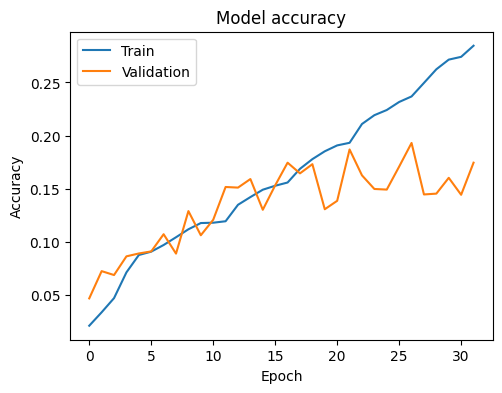

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

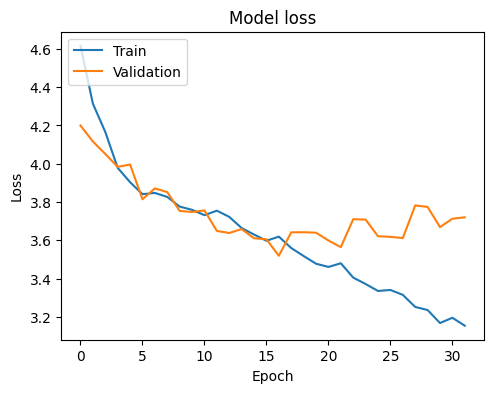

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset_batched, steps=7)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 101s 14s/step - accuracy: 0.1699 - loss: 3.5867
Test Loss: 3.6082763671875
Test Accuracy: 0.15893664956092834


In [ ]:
img=tf.io.read_file(f'{test_dir}/Akarna_Dhanurasana/image_1.jpg')
img=tf.image.decode_jpeg(img, channels=3)
results=pose.process(img.numpy())

In [ ]:
features = [[lm.x, lm.y, lm.z] for lm in results.pose_landmarks.landmark]
joint_angles = extract_joint_angles(np.array(features))
body_ratios = extract_body_ratios(np.array(features))
filtered_keypoints = np.concatenate([keypoints[:1], keypoints[7:9], keypoints[11:]], axis=0)
features_vector = np.concatenate([filtered_keypoints, joint_angles, body_ratios], axis=0)
ypred=model.predict(np.array([features_vector])).argmax(axis=1)
print('Pose Predicted:', label_lookup.get_vocabulary()[ypred[0]])

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [ ]:
label_lookup.save_assets('label_lookup_')

In [ ]:
model = tf.keras.models.load_model('yoga_trainer_model.keras')

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Define the number of steps to take from the test dataset
num_test_steps = 7 # Using the same number of steps as model evaluation

# Get true labels and predictions for a fixed number of batches
true_labels = []
predictions = []

for i, (x, y) in enumerate(test_dataset_batched.take(num_test_steps).as_numpy_iterator()):
    true_labels.extend(y)
    batch_predictions = model.predict(x).argmax(axis=1)
    predictions.extend(batch_predictions)

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Generate classification report
class_names = label_lookup.get_vocabulary()
report = classification_report(true_labels, predictions, target_names=class_names)

In [ ]:
print(report)

In [ ]:
import pandas as pd
import io

# The classification report is a string, so we can read it like a file
report_io = io.StringIO(report)

# Read the report into a pandas DataFrame, skipping the header and taking the first few columns
# The actual column names will be set later
df_report = pd.read_csv(report_io, sep='\s+', skiprows=[0], header=None, index_col=0, usecols=[0, 1, 2, 3, 4])

# Rename the columns to be more descriptive
df_report.columns = ['precision', 'recall', 'f1-score', 'support']

# Display the DataFrame
display(df_report)

In [ ]:
df_report.sort_values(by='precision').head(20)

In [ ]:
import numpy as np
from collections import Counter

def analyze_model_mistakes(y_true, y_pred):
    """Return per-class top 5 incorrect predictions and total incorrect counts."""

    # Get the unique true classes
    unique_true_classes = np.unique(y_true)

    # Initialize per-class error tracking and total counts
    class_errors = {class_id: [] for class_id in unique_true_classes}
    total_incorrect_counts = {class_id: 0 for class_id in unique_true_classes}

    # Populate mistakes and count totals
    for true_label, pred_label in zip(y_true, y_pred):
        if true_label != pred_label:
            class_errors[true_label].append(pred_label)
            total_incorrect_counts[true_label] += 1


    # Analyze top 5 mistakes for each class and sort by count
    top_mistakes = {}
    for class_id, mistakes in class_errors.items():
        counter = Counter(mistakes)
        # Sort by count in descending order
        most_common = sorted(counter.items(), key=lambda item: item[1], reverse=True)[:5]
        top_mistakes[class_id] = most_common

    return top_mistakes, total_incorrect_counts

# Assuming 'true_labels' and 'predictions' are already available from the classification report cell
top_mistakes_per_class, total_incorrect_counts_per_class = analyze_model_mistakes(true_labels, predictions)

# Sort classes by total incorrect counts in descending order
sorted_classes_by_mistakes = sorted(total_incorrect_counts_per_class.items(), key=lambda item: item[1], reverse=True)

# Display results:
print("Top 5 incorrect predictions per class (sorted by total incorrect counts):")
for class_id, total_count in sorted_classes_by_mistakes:
    true_class_name = label_lookup.get_vocabulary()[class_id]
    print(f"\nTrue Class: {true_class_name} - Total incorrect predictions: {total_count} times - Top 5 incorrect predictions:")
    mistakes = top_mistakes_per_class.get(class_id, []) # Get top mistakes for this class

    if mistakes:
        for wrong_class_id, count in mistakes:
            wrong_class_name = label_lookup.get_vocabulary()[wrong_class_id]
            print(f"   Predicted as: {wrong_class_name} : {count} times")
    else:
        print("   No incorrect predictions for this class in the test set.")

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif

# Assuming:
# X_train: shape (num_samples, num_features)
# y_train: shape (num_samples,)

feature_names = [f'feature_{i}' for i in range(total_features)]

# Limit the number of samples for analysis to avoid interruptions
limit = 65 # You can adjust this value

x_data = [x for x, _ in validation_dataset_batched.take(limit).unbatch().as_numpy_iterator()]
y_data = [y for _, y in validation_dataset_batched.take(limit).unbatch().as_numpy_iterator()]

# Convert the lists to numpy arrays
X_data = np.array(x_data)
y_data = np.array(y_data)

NameError: name 'validation_dataset' is not defined

In [ ]:
# Calculate the mean of each feature for each class
mean_features_per_class = pd.DataFrame(X_data, columns=feature_names).groupby(y_data).mean()

# # Display the resulting DataFrame
# display(mean_features_per_class)

# Plot a heatmap of the mean feature values per class
plt.figure(figsize=(41, 50))
sns.heatmap(mean_features_per_class.T, cmap='viridis', annot=True)
plt.title('Mean Feature Values per Class')
plt.xlabel('Class ID')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Now that the datasets are scaled, you can use the scaled datasets for training and evaluation.